In [1]:
# !pip install shap
# !pip install pdpbox

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import plot_partial_dependence
import math
import sklearn.ensemble as ens
from scipy import stats
pd.set_option("display.max_columns", None)

from pdpbox import pdp, get_dataset, info_plots


In [3]:
# Dataset already encoded and split - Sato set this up elsewhere
train = pd.read_csv('application_data_train.csv')
valid = pd.read_csv('application_data_valid.csv')
test = pd.read_csv('application_data_test.csv')

# imports the full dataset for this preliminary exploration only--
# other than this section, the train, test, validation split data is used
app_data = pd.read_csv('application_data.csv')



In [4]:


# app_data=app_data.drop(labels=Flag, axis=1)
# train=train.drop(labels=Flag, axis=1)
# test=test.drop(labels=Flag, axis=1)


# Preliminary Data Exploration
* Pearson correlation matrix
* Demographic breakdown of target = 1, 0


In [5]:
data = app_data

### Pearson correlation
* Pearson correlation value for each pair of features

In [6]:
# # Correlations with respect to TARGET. Then, sort.
# correlations = data.corr()['TARGET'].sort_values()

# # most positive and most negative
# print('most positive:\n', correlations.tail(5))
# print('most negative:\n', correlations.head(5))

In [7]:
# # Correlation matrix including Flag variables

# sns.set(style="whitegrid", font_scale=1)
# plt.figure(figsize=(12,12))
# plt.title('Pearson Correlation Matrix',fontsize=25)
# sns.heatmap(app_data.corr(),linewidths=0.2,vmax=0.8,square=True,cmap="GnBu",linecolor='b',
#             annot=False, cbar_kws={"shrink": .7})

In [8]:
# Correlation matrix excluding Flag variables

# flag variables assiciated with application documents provided
Flag=['FLAG_MOBIL','FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
      'FLAG_PHONE', 'FLAG_EMAIL','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 
      'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
      'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
      'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
      'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

# We may drop Flag variables
app_df_2=app_data.drop(labels=Flag, axis=1)

# sns.set(style="whitegrid", font_scale=1)
# plt.figure(figsize=(12,12))
# plt.title('Pearson Correlation Matrix',fontsize=25)
# sns.heatmap(app_df_2.corr(),linewidths=0.2,vmax=0.8,square=True,cmap="GnBu",linecolor='b',
#             annot=False, cbar_kws={"shrink": .7})

In [9]:
# # I was playing around with dropping these features earlier but it's not necessary
# aug_data=aug_data.drop(labels=Flag, axis=1)
# aug_data=aug_data.drop(labels=['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'], axis=1)

### Summary statistics

In [10]:
#Checking the distribution of target variable
default=app_data[app_data.TARGET==1]
nondef=app_data[app_data.TARGET==0]
percentage_defaulters=((len(default))/len(app_data)) * 100
percentage_defaulters

8.072881945686495

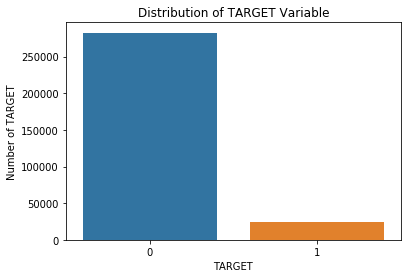

In [11]:
sns.countplot(app_data.TARGET)
plt.xlabel("TARGET")
plt.ylabel("Number of TARGET")
plt.title("Distribution of TARGET Variable")
plt.show()

this is the percentage of cat2check: 90.47871458256778


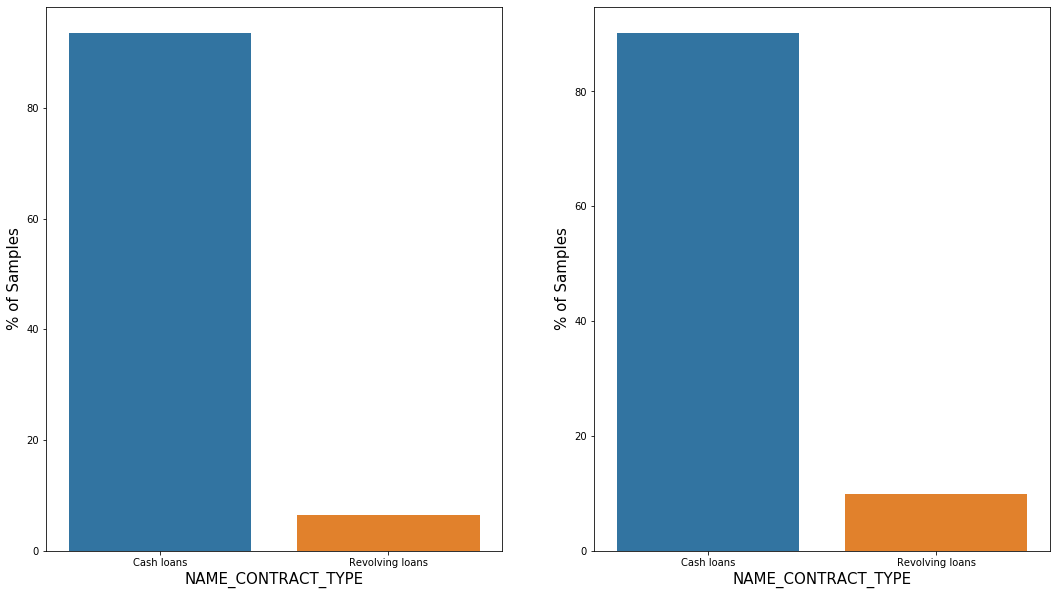

In [12]:
# Plot categorical data -- type of loan
categ = 'NAME_CONTRACT_TYPE'

# calculates the percentage for the desired categorial variable value
cat2check=app_data[app_data[categ]=='Cash loans']
catnot2check=app_data[app_data[categ]!='Cash loans']
percentage_cat2check=(len(cat2check)*100)/(len(cat2check)+len(catnot2check))
print('this is the percentage of cat2check:',percentage_cat2check)

# does the plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
s1=sns.barplot(ax=ax1,x=default[categ].value_counts().index, data=default, y= default[categ].value_counts(normalize=True) * 100)
# s1.set_xticklabels(s1.get_xticklabels(),rotation=90,fontsize=12)
ax1.set_xlabel('%s' %categ,fontsize=15)
ax1.set_ylabel("% of Samples",fontsize=15)

s2=sns.barplot(ax=ax2,x=nondef[categ].value_counts().index, data=nondef, y= (nondef[categ].value_counts(normalize=True))*100)
# s2.set_xticklabels(s2.get_xticklabels(),rotation=90,fontsize=12)
ax2.set_xlabel('%s' %categ, fontsize=15)
ax2.set_ylabel("% of Samples", fontsize=15)
plt.show()

this is the percentage of males: 34.164306317497584


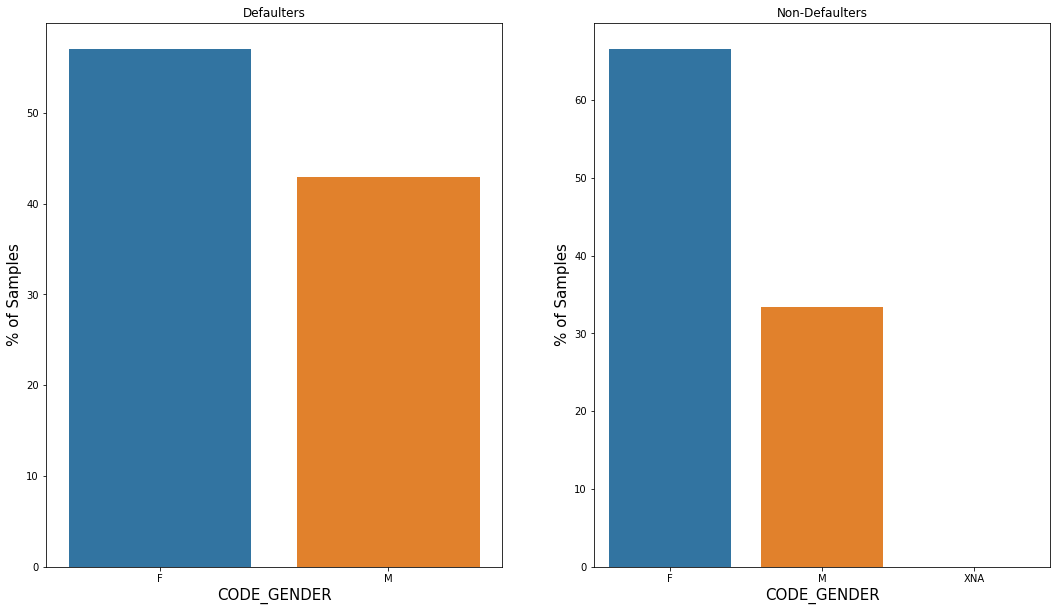

In [13]:
# Plot categorical data -- gender breakdown
categ = 'CODE_GENDER'

# calculates the percentage for the desired categorial variable value
cat2check=app_data[app_data[categ]=='M']
catnot2check=app_data[app_data[categ]!='M']
percentage_cat2check=(len(cat2check)*100)/(len(cat2check)+len(catnot2check))
print('this is the percentage of males:',percentage_cat2check)

# does the plotting!
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
s1=sns.barplot(ax=ax1,x=default[categ].value_counts().index, data=default, y= default[categ].value_counts(normalize=True) * 100)
# s1.set_xticklabels(s1.get_xticklabels(),rotation=90,fontsize=12)
ax1.set_title('Defaulters')
ax1.set_xlabel('%s' %categ,fontsize=15)
ax1.set_ylabel("% of Samples",fontsize=15)

s2=sns.barplot(ax=ax2,x=nondef[categ].value_counts().index, data=nondef, y= (nondef[categ].value_counts(normalize=True))*100)
# s2.set_xticklabels(s2.get_xticklabels(),rotation=90,fontsize=12)
ax2.set_title('Non-Defaulters')
ax2.set_xlabel('%s' %categ, fontsize=15)
ax2.set_ylabel("% of Samples", fontsize=15)
plt.show()

this is the percentage of house/apartment: 88.73438673738501


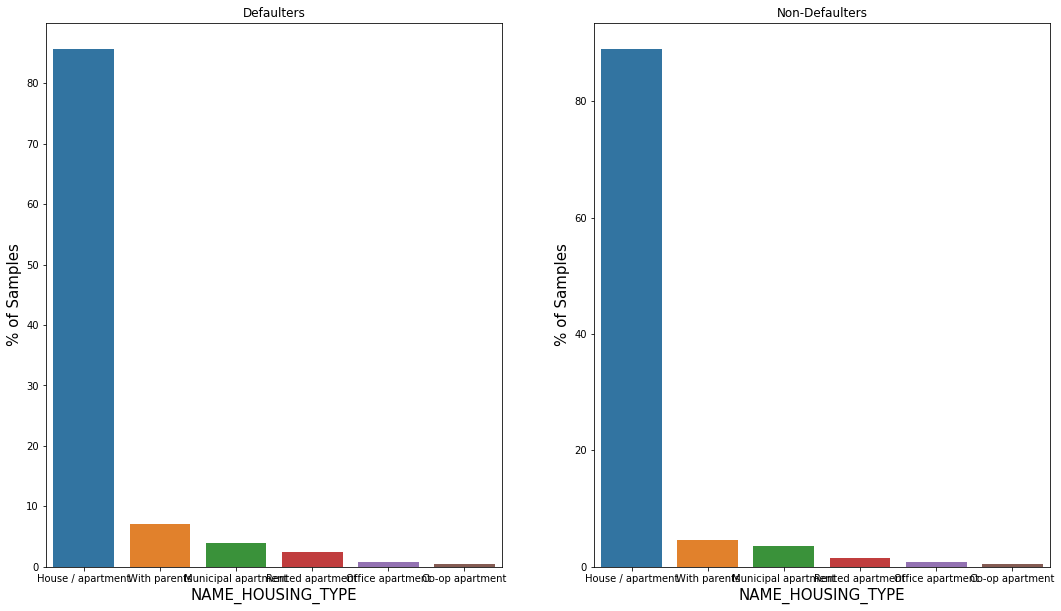

In [14]:
# Plot categorical data -- gender breakdown
categ = 'NAME_HOUSING_TYPE'

# calculates the percentage for the desired categorial variable value
cat2check=app_data[app_data[categ]=='House / apartment']
catnot2check=app_data[app_data[categ]!='House / apartment']
percentage_cat2check=(len(cat2check)*100)/(len(cat2check)+len(catnot2check))
print('this is the percentage of house/apartment:',percentage_cat2check)

# does the plotting!
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
s1=sns.barplot(ax=ax1,x=default[categ].value_counts().index, data=default, y= default[categ].value_counts(normalize=True) * 100)
# s1.set_xticklabels(s1.get_xticklabels(),rotation=90,fontsize=12)
ax1.set_title('Defaulters')
ax1.set_xlabel('%s' %categ,fontsize=15)
ax1.set_ylabel("% of Samples",fontsize=15)

s2=sns.barplot(ax=ax2,x=nondef[categ].value_counts().index, data=nondef, y= (nondef[categ].value_counts(normalize=True))*100)
# s2.set_xticklabels(s2.get_xticklabels(),rotation=90,fontsize=12)
ax2.set_title('Non-Defaulters')
ax2.set_xlabel('%s' %categ, fontsize=15)
ax2.set_ylabel("% of Samples", fontsize=15)
plt.show()

### Checking back in on the selected features
* FLAG_DOCUMENT9/15/16
* OCCUPATION_TYPE_Advertising
* OCCUPATION_TYPE_Secretaries
Continuous (not looked at here :( )
* external sources (1, 2, and 3)
* two residence things (totalarea_mode, nonlivingarea_avg)


cat2check 1198
catnot2check 306313
this is the percentage of 1: 0.389579559755586
percent defaulters: 0.2980866062437059
percent nondefaulters: 0.3976143141153082


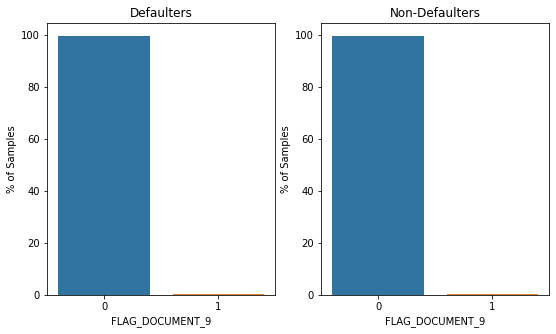

In [15]:
# note the layout for the plot is used from a repo
# Plot categorical data -- gender breakdown
categ = 'FLAG_DOCUMENT_9'

# calculates the percentage for the desired categorial variable value
cat2check=app_data[app_data[categ]==1]
catnot2check=app_data[app_data[categ]==0]
percentage_cat2check=(len(cat2check)*100)/(len(cat2check)+len(catnot2check))
print('cat2check',len(cat2check))
print('catnot2check',len(catnot2check))
print('this is the percentage of 1:',percentage_cat2check)


print('percent defaulters:',(len(default[default[categ]==1]
)*100)/(len(default[default[categ]==1]
)+len(default[default[categ]!=1]
)))
print('percent nondefaulters:',(len(nondef[nondef[categ]==1]
)*100)/(len(nondef[nondef[categ]==1]
)+len(nondef[nondef[categ]!=1]
)))


# does the plotting!
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,5))
s1=sns.barplot(ax=ax1,x=default[categ].value_counts().index, data=default, y= default[categ].value_counts(normalize=True) * 100)
ax1.set_title('Defaulters')
ax1.set_xlabel('%s' %categ)
ax1.set_ylabel("% of Samples")

s2=sns.barplot(ax=ax2,x=nondef[categ].value_counts().index, data=nondef, y= (nondef[categ].value_counts(normalize=True))*100)
ax2.set_title('Non-Defaulters')
ax2.set_xlabel('%s' %categ)
ax2.set_ylabel("% of Samples")
plt.show()

In [16]:
# # Plot categorical data -- gender breakdown
# categ = 'ORGANIZATION_TYPE'

# # calculates the percentage for the desired categorial variable value
# cat2check=app_data[app_data[categ]=='Advertising']
# catnot2check=app_data[app_data[categ]!='Advertising']
# percentage_cat2check=(len(cat2check)*100)/(len(cat2check)+len(catnot2check))
# print('cat2check',len(cat2check))
# print('catnot2check',len(catnot2check))
# print('this is the percentage of 1:',percentage_cat2check)

# print('percent defaulters:',(len(default[default[categ]=='Advertising']
# )*100)/(len(default[default[categ]=='Advertising']
# )+len(default[default[categ]!='Advertising']
# )))
# print('percent nondefaulters:',(len(nondef[nondef[categ]=='Advertising']
# )*100)/(len(nondef[nondef[categ]=='Advertising']
# )+len(nondef[nondef[categ]!='Advertising']
# )))




# # does the plotting!
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,10))
# s1=sns.barplot(ax=ax1,x=default[categ].value_counts().index, data=default, y= default[categ].value_counts(normalize=True) * 100)
# ax1.set_title('Defaulters')
# ax1.set_xlabel('%s' %categ)
# ax1.set_ylabel("% of Samples")
# s1.set_xticklabels(s1.get_xticklabels(),rotation=90,fontsize=12)

# s2=sns.barplot(ax=ax2,x=nondef[categ].value_counts().index, data=nondef, y= (nondef[categ].value_counts(normalize=True))*100)
# ax2.set_title('Non-Defaulters')
# ax2.set_xlabel('%s' %categ)
# ax2.set_ylabel("% of Samples")
# s2.set_xticklabels(s2.get_xticklabels(),rotation=90,fontsize=12)

# plt.show()

# Preprocessing

In [17]:
def prepare_for_logreg(data):
  # # The One Hot Encode was already done when the dataset was split, so it is not necessary here
  # # One Hot Encode
  # to_encode = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
  #             'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
  #             'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
  #             'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE' ]

  # encoded = pd.get_dummies(to_encode)
  # data.drop(to_encode, axis = 1, inplace  = True)
  # data.merge(encoded, left_index= True, right_index = True)
  
  # Remove outliers - 4422 out of 215257
  # ids_to_remove = train[(np.abs(stats.zscore(train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE']])) >= 3)].SK_ID_CURR.unique()
  ids_to_remove = data[(np.abs(stats.zscore(data[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE']])) >= 3)].SK_ID_CURR.unique()
  data = data[~data.SK_ID_CURR.isin(ids_to_remove)]
  
  # Remove features with correlation above 0.95
  columns_to_remove = ['NAME_CONTRACT_TYPE_Cash loans', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_N', 'CODE_GENDER_F', 'ORGANIZATION_TYPE_XNA', 'FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MEDI', 'FLOORSMAX_MEDI', 'ENTRANCES_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'FLOORSMAX_MODE', 'AMT_GOODS_PRICE', 'ELEVATORS_MEDI', 'LANDAREA_MEDI', 'COMMONAREA_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'ELEVATORS_MODE', 'COMMONAREA_MODE', 'ENTRANCES_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'APARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'REGION_RATING_CLIENT_W_CITY']
  data = data.drop(columns_to_remove, axis = 1)
    
  # Fill NaN
  data = data.fillna(data.mean())
    
  # Drop ID
  data = data.drop('SK_ID_CURR', axis = 1)
  
  return data

In [18]:
def prepare_test_data(data):
  ids_to_remove = data[(np.abs(stats.zscore(data[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE']])) >= 3)].SK_ID_CURR.unique()
  data = data[~data.SK_ID_CURR.isin(ids_to_remove)]
  
  # Remove features with correlation above 0.95
  columns_to_remove = ['NAME_CONTRACT_TYPE_Cash loans', 'FLAG_OWN_CAR_N', 'FLAG_OWN_REALTY_N', 'CODE_GENDER_F', 'ORGANIZATION_TYPE_XNA', 'FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BUILD_MEDI', 'FLOORSMIN_MEDI', 'FLOORSMAX_MEDI', 'ENTRANCES_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'LANDAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'FLOORSMAX_MODE', 'AMT_GOODS_PRICE', 'ELEVATORS_MEDI', 'LANDAREA_MEDI', 'COMMONAREA_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'ELEVATORS_MODE', 'COMMONAREA_MODE', 'ENTRANCES_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'APARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'REGION_RATING_CLIENT_W_CITY']
  data = data.drop(columns_to_remove, axis = 1)
    
  # Fill NaN
  data = data.fillna(data.mean())
    
  # Drop ID
  data = data.drop('SK_ID_CURR', axis = 1)
  
  return data

In [19]:
train_new = prepare_for_logreg(train)

In [20]:
test_new = prepare_test_data(test)

In [21]:
train = train_new
test = test_new

## Drop document flag features
* to see which of the more quantitative demographics affect the outcome 

In [22]:
Flag=['FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

# We may drop Flag variables
trainlist = train.columns.values.tolist()
cols2drop = [value for value in Flag if value in trainlist]
train=train.drop(labels=cols2drop, axis=1)

testlist = test.columns.values.tolist()
cols2drop = [value for value in Flag if value in testlist]
test=test.drop(labels=cols2drop, axis=1)

In [23]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATI

In [24]:
test

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATI

## Normalize the dataset
* see title

In [25]:
# NORMALIZE
# robust scaler transform of the data ()
# trans = MinMaxScaler()
# data = trans.fit_transform(data)
# data = pd.DataFrame(data)
data = train
normalized_df=(data-data.min())/(data.max()-data.min())
data = normalized_df


# Balance the dataset
* Three methods were written from scratch - random undersampling, random oversampling, and SMOTE
* In our exploratory analysis, we had better performance from the random oversampling compared to the other methods
* The other two methods are still included below, but are commented out

### Random Undersampling
* Separates data where target = 1 and target = 0
* keeps only a subset of samples where target = 0 such that the ratio between the two classes is 50-50

In [26]:
# # separate all datapoints where target = 1, append them back onto the dataset multiple times
# zero_vals = data.loc[data['TARGET'] == 0]
# one_vals = data.loc[data['TARGET'] == 1]
# # data.append(one_vals)
# # data.append(one_vals)
# print('this is orig size',data.shape)

# print('this is zero vals size',zero_vals.shape)
# print('this is one vals size',one_vals.shape)

# # a = one_vals, b = zerovals + onevals
# # a/b = 0.08 current
# # a/(b-x) = 0.5 desired
# # a = 0.5b - 0.5x
# # a/0.5 = b-x
# # b  - a/.5  = x = number of samples to remove from b

# a = len(one_vals)
# b = len(zero_vals)
# # hardcoded the equation above, 
# x = (b + a) - (a/0.5)
# tokeep = int(b - x)
# newzero_vals = zero_vals[:tokeep]

# print('this is new zero vals size',newzero_vals.shape)

# newdata = newzero_vals
# one_vals.TARGET.sum()

# newdata = newdata.append(one_vals)
#   # return newdata

# aug_data = newdata.append(one_vals) # aug data is more balanced - original data was unbalanced classifier
# newzero_vals.TARGET.sum()
# one_vals.TARGET.sum()
# aug_data.TARGET.sum()
# one_vals.shape

# outflag = 'Randomly Undersampled Dataset'


### Random Oversampling
* Separates data where target = 1 and target = 0
* Duplicates samples where target = 1 until the ratio between the two classes is 50-50
* Randomly draws from this new dataset to run analyses

In [27]:
data = train
# separate all datapoints where target = 1, append them back onto the dataset multiple times
zero_vals = data.loc[data['TARGET'] == 0]
one_vals = data.loc[data['TARGET'] == 1]
print('this is the orig size',data.shape)

print('this is zero vals size',zero_vals.shape)
print('this is one vals size',one_vals.shape)

# this is my math for getting the desired prevalence
# a = one_vals, b = zero_vals
# desired: newa/b = 0.5 => newa = 0.5b
# x = newa - a (this needs to be added to a s.t. )
# a/(b-x) = 0.5 desired
# a = 0.5b - 0.5x
# a/0.5 = b-x
# b  - a/.5  = x = number of samples to remove from b

desired_prevalence = 0.5
# hardcoded the equation above, 
a = len(one_vals)
b = len(zero_vals)
newa  = b*desired_prevalence / (1-desired_prevalence)
duplicates2make = math.floor(newa/a) # 0 if a already 50%, 1 id a is 25%, etc.
#^^floor function is arbitrary, could also be ceil

newdata = one_vals
for i in range(duplicates2make):
  newdata = newdata.append(one_vals)
# print('this is new data shape',newdata.shape)

aug_data = data.append(newdata)





this is the orig size (210835, 181)
this is zero vals size (193720, 181)
this is one vals size (17115, 181)


### SMOTE
* Separates data where target = 1 and target = 0
* keeps only a subset of samples where target = 0 such that the ratio between the two classes is 50-50

In [28]:
# # separate all datapoints where target = 1, append them back onto the dataset multiple times
# zero_vals = data.loc[data['TARGET'] == 0]
# one_vals = data.loc[data['TARGET'] == 1]
# synth_data = pd.DataFrame(columns=data.columns)
# synth_data = synth_data.drop('TARGET', axis = 1)

# # # # # # # # # # Synthetic Minority Oversampling TEchnique (SMOTE)
# derired_prevalence = 0.3
# # number of synth examples to make for desired prevalence
# synth2add = (derired_prevalence*len(zero_vals) + len(one_vals)*(derired_prevalence-1))/(1-derired_prevalence)

# # find the k nearest neighbors to the randomly sampled datapoint

# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(one_vals.drop('TARGET', axis = 1), one_vals.TARGET, test_size=0.20)
# # _, x_test, _, y_test = train_test_split(data.drop('TARGET', axis = 1), data.TARGET, test_size=0.25, random_state=None)

# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(n_neighbors=5)
# classifier.fit(X_train, Y_train) # up this number from 100 later
# # classifier.fit(X_train[:10000], Y_train[:10000]) # up this number from 100 later

# print('this is the total number to add:',int(synth2add))

# for i in range(int(synth2add)):
#   # randomly sample a single value from the minority dataset
#   rand_sample = one_vals.sample()
#   rand_sample = rand_sample.drop('TARGET', axis = 1)

#   neigh_dist, neigh_ind = classifier.kneighbors(rand_sample, n_neighbors=5, return_distance=True)
#   # print(neigh_ind)

#   # randomly choose a new datapoint from the k-nearest neighbors
#   neigh_ind = neigh_ind.flatten()
#   idx2interp = np.random.choice(neigh_ind)

#   rand_sample2 = one_vals.iloc[idx2interp]
#   # print(type(rand_sample2))

#   # create a new, synthetic, datapoint between the original sample and the 
#   # <<interpolate between rand_sample and rand_sample2>>
#   rand_sample = rand_sample.squeeze() # conver rand_sample from dataframe to series
#   synth = np.sqrt([(a-b)*(a-b) for a, b in zip(rand_sample, rand_sample2)])
#   synth = pd.DataFrame(synth.reshape((1, 105)), columns=list(synth_data.columns))

#   # synth = pd.Series(synth)    
#   # print(synth)
#   # synth_data = one_vals.append(synth)
#   # print(pd.DataFrame(synth).T)
#   # synth_data = synth_data.append(pd.DataFrame(synth).T)
#   synth_data = synth_data.append(synth)
#   if i % 1000 == 0:
#     print('this is i:',i)
#     # print(pd.DataFrame(synth).T)

# # print(synth_data)

# one_vals.drop('TARGET',axis=1)
# newones = one_vals.append(synth_data)
# print(len(synth_data))
# print(len(one_vals))

# print(len(newones))
# newones['TARGET'] = 1
# aug_data = zero_vals.append(newones, ignore_index=True)
# # TODO: 1. put this into a for loop for i = 1:synth2add
# # 2. create synth_data df to append the synthetic points to in each cycle
# # 3. after the loop runs, append the synth_data to the original data and continue
# outflag = 'SMOTE Dataset'


### Info on the augmented dataset
* Size of zeros, ones, total
* Prevalence

In [29]:
zero_vals = aug_data.loc[aug_data['TARGET'] == 0]
one_vals = aug_data.loc[aug_data['TARGET'] == 1]
# zero_vals = aug_data.loc[data['TARGET'] == 0]
# one_vals = aug_data.loc[data['TARGET'] == 1]
print('zero vals len',len(zero_vals))
print('one vals len',len(one_vals))
print("prevalence:",len(one_vals)/len(aug_data))
print('the total size is :',len(aug_data))

aug_data_holding = aug_data

zero vals len 193720
one vals len 222495
prevalence: 0.5345674711387144
the total size is : 416215


# Define Models

In [30]:
# Logistic Regression with Lasso regularization
model = LogisticRegression(penalty='l1', solver='liblinear') #check liblinear

In [31]:
# separate the train data into x and y data
x_train=train.loc[:,train.columns != 'TARGET']
y_train=train['TARGET']

# separate the test data into x and y data
test = test.fillna(test.mean())
x_test=test.loc[:,test.columns != 'TARGET']
y_test=test['TARGET']


# Interpretations

## Feature Importance

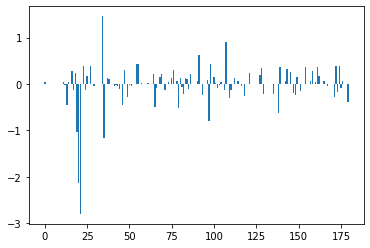

In [32]:
# Add title here 
model.fit(x_train.iloc[:20000,:], y_train[:20000])

importance = model.coef_[0]
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [33]:
# Feature Selection - Only variables that have abs(weight) larger than 0.2

coefficients = pd.DataFrame(zip(x_train.columns, np.abs(model.coef_[0])), columns = ['variable', 'coeff'])
selected_features = list(coefficients.sort_values('coeff', ascending= False).head(10).variable)

selected_features.append('AMT_CREDIT')
selected_features.append('DAYS_BIRTH')
selected_features.append('DAYS_REGISTRATION')

coefficients.sort_values('coeff', ascending= False).head(10)


,variable,coeff
21,EXT_SOURCE_3,2.802440
20,EXT_SOURCE_2,2.125754
34,NONLIVINGAREA_AVG,1.461566
35,TOTALAREA_MODE,1.167233
19,EXT_SOURCE_1,1.029402
107,ORGANIZATION_TYPE_Advertising,0.898849
97,OCCUPATION_TYPE_Secretaries,0.789091
138,ORGANIZATION_TYPE_Military,0.631315
91,OCCUPATION_TYPE_Low-skill Laborers,0.624227
79,NAME_HOUSING_TYPE_Office apartment,0.524708


## Plotting


In [34]:
# # confusion matrix - from matheus
# y_hat = model.predict(x_test)
# cf_matrix = confusion_matrix(y_hat,y_test)
# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
# ax.set_title('Confusion Matrix for Logistic Regression')
# ax.set_ylabel('\nPredicted Values')
# ax.set_xlabel('Actual Values ');

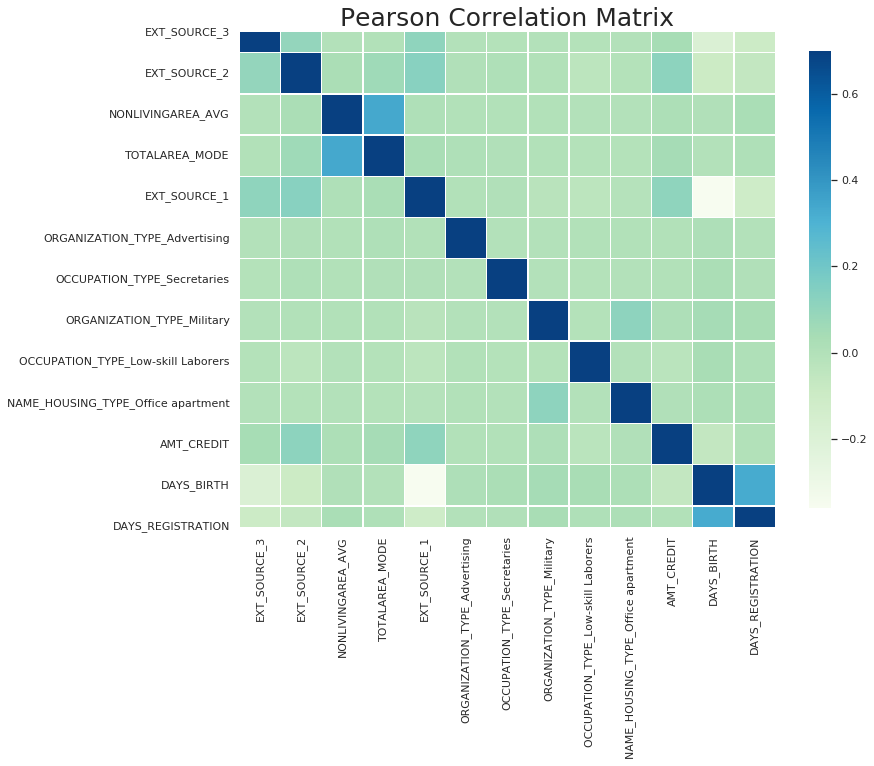

In [35]:
# pearson correlation matrix of the selected features
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(train[selected_features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=False, cbar_kws={"shrink": .7})

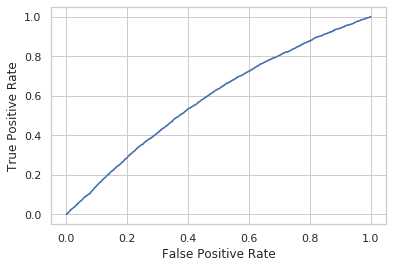

In [36]:
# Plot ROC-AUC curve

# new model with just the selected features
model2 = LogisticRegression()
model2.fit(x_train[selected_features], y_train)

y_pred_proba = model2.predict_proba(x_test[selected_features])[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:

# # only looking at the selected features now
# # cannot leave this open at the same time as partial dependance plots or else aug_data_holding gets rewritten :(
# aug_data_selected = aug_data
# aug_data_selected.drop(columns=[col for col in aug_data_selected if col not in selected_features], inplace=True)

# sns.set(style="whitegrid", font_scale=1)
# plt.figure(figsize=(10,10))
# plt.title('Pearson Correlation Matrix',fontsize=25)
# sns.heatmap(aug_data_selected.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
#             annot=False, cbar_kws={"shrink": .7})

# Partial dependence plots

In [38]:
# this graph type came from matheus

In [39]:
def plot_a_pdp_pls(curr_feat):
  fig = plt.figure(figsize=(16, 12))

  pdp_extsrc2 = pdp.pdp_isolate(model=model, dataset=x_test, model_features=x_test.columns, feature=curr_feat)
  pdp.pdp_plot(pdp_extsrc2, curr_feat)
  plt.show()

<Figure size 1152x864 with 0 Axes>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


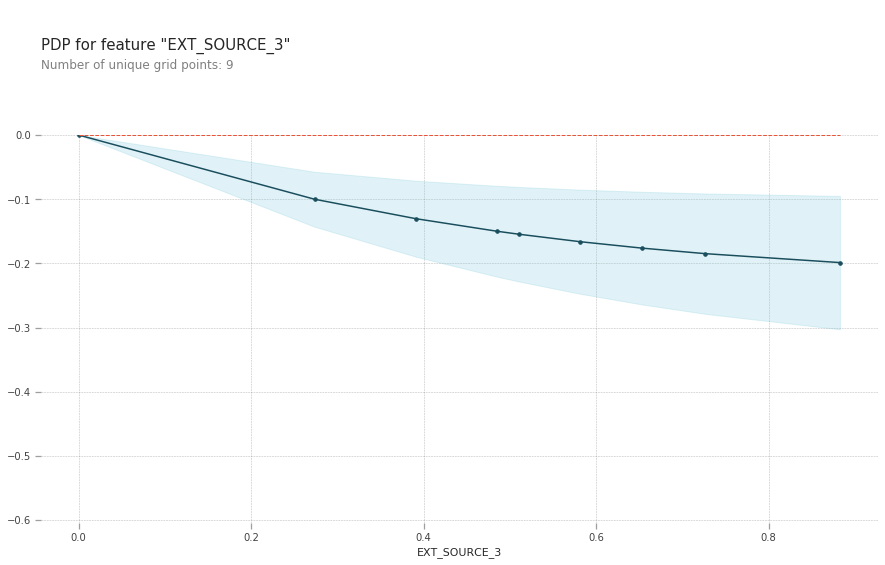

<Figure size 1152x864 with 0 Axes>

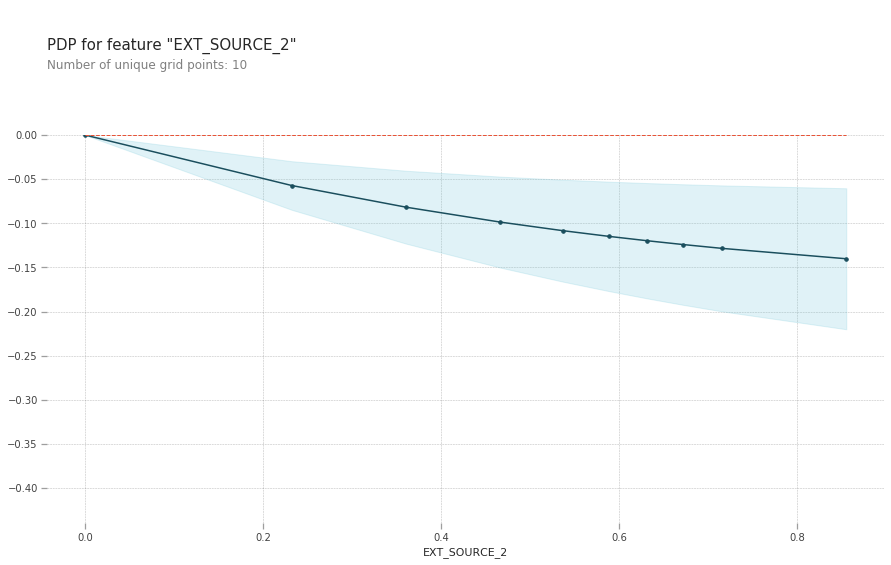

<Figure size 1152x864 with 0 Axes>

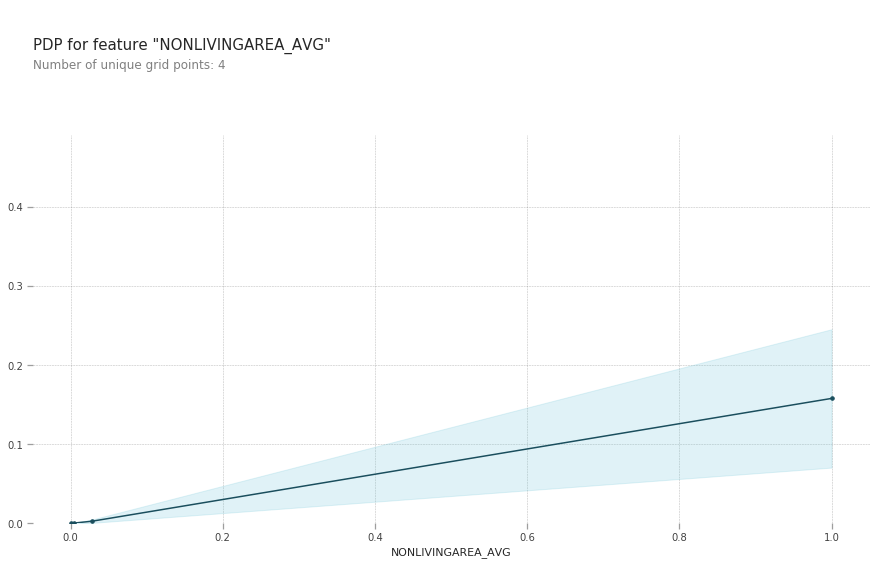

<Figure size 1152x864 with 0 Axes>

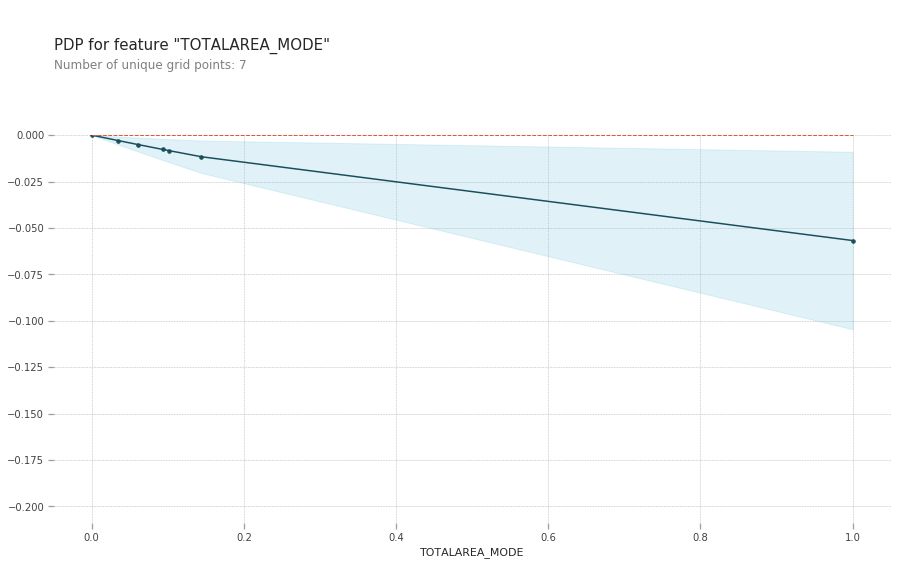

<Figure size 1152x864 with 0 Axes>

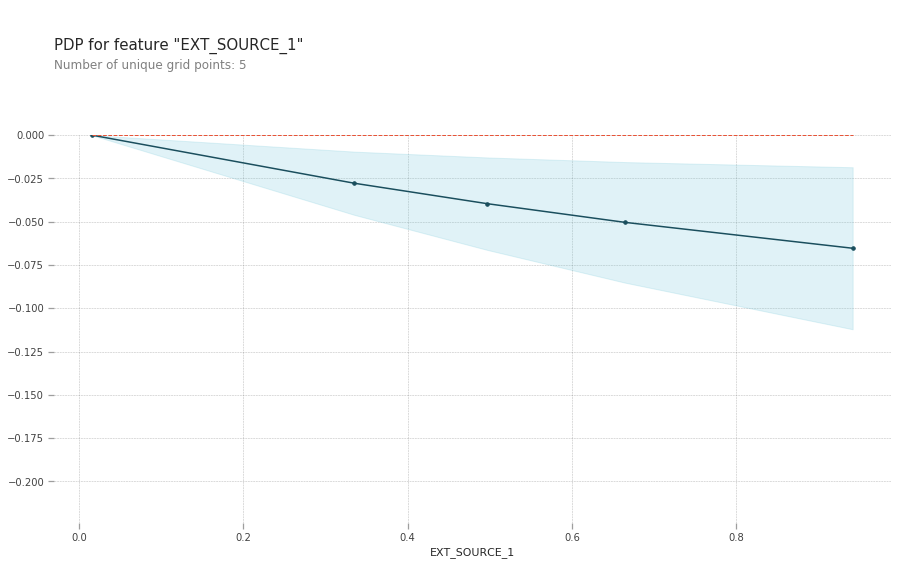

<Figure size 1152x864 with 0 Axes>

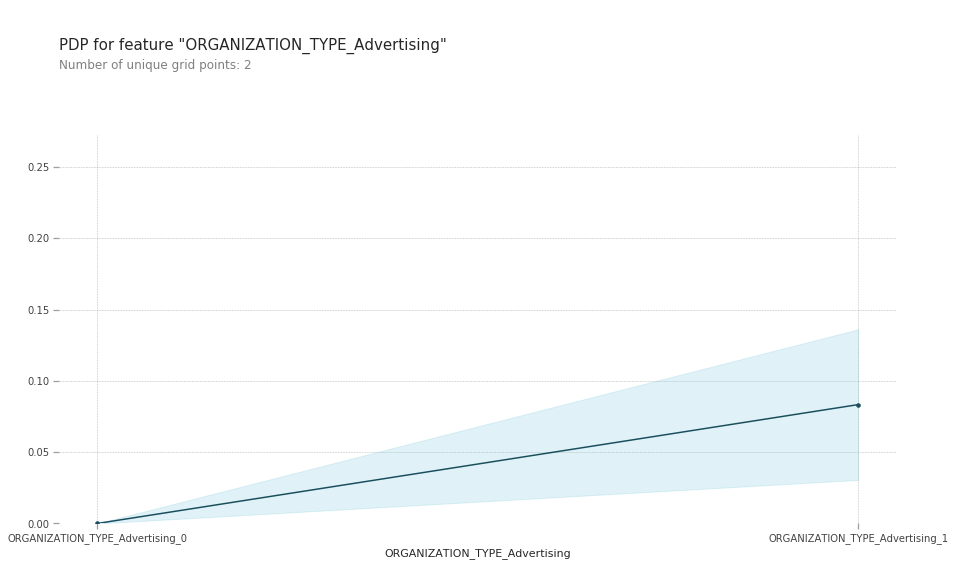

<Figure size 1152x864 with 0 Axes>

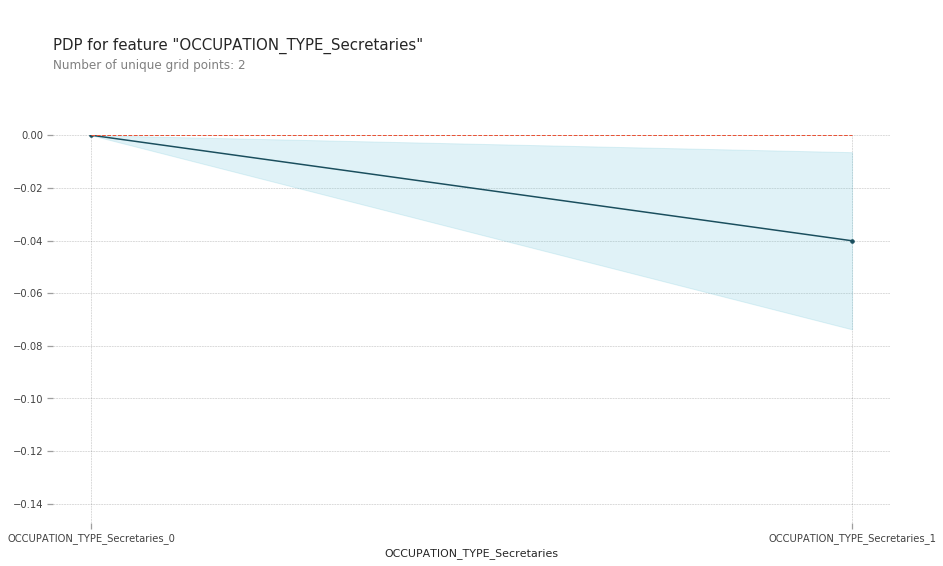

<Figure size 1152x864 with 0 Axes>

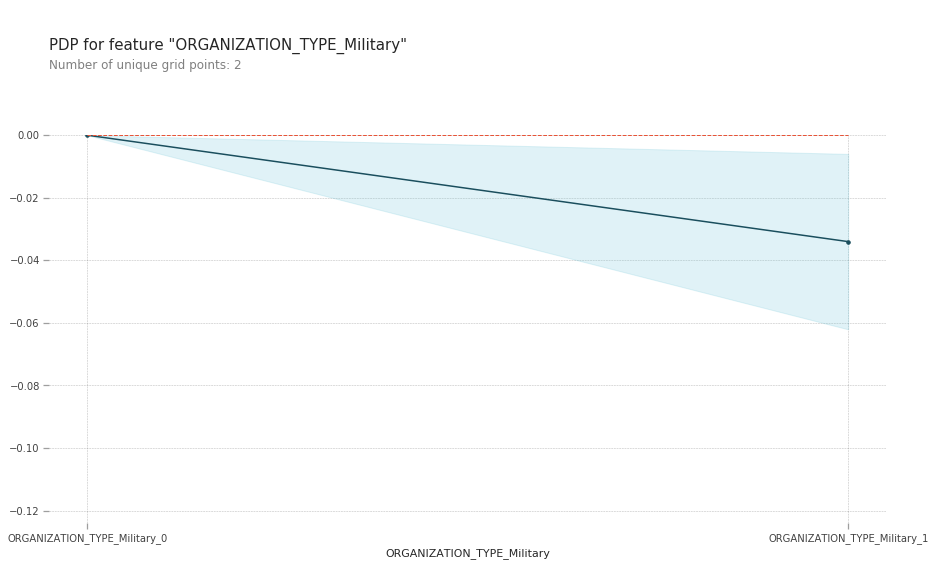

<Figure size 1152x864 with 0 Axes>

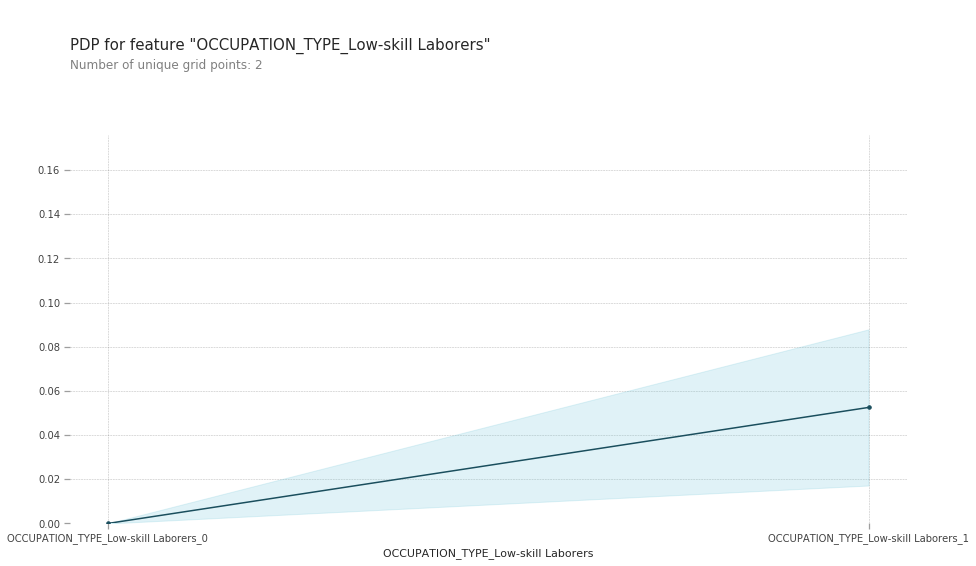

<Figure size 1152x864 with 0 Axes>

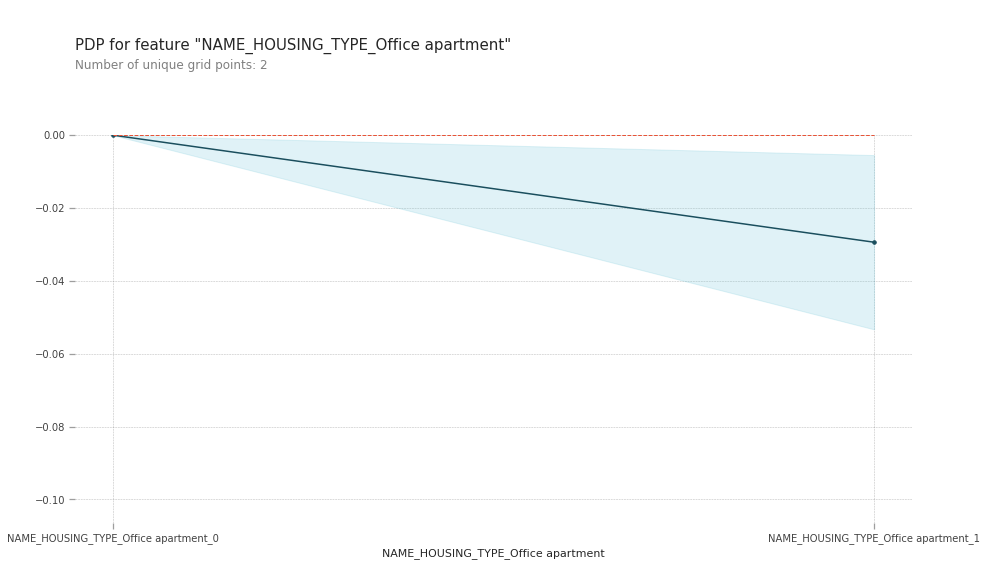

<Figure size 1152x864 with 0 Axes>

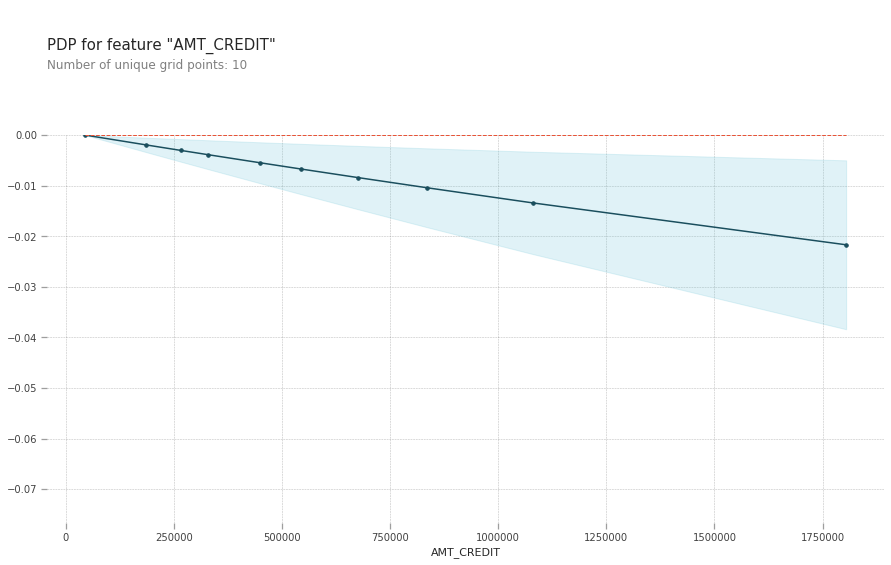

<Figure size 1152x864 with 0 Axes>

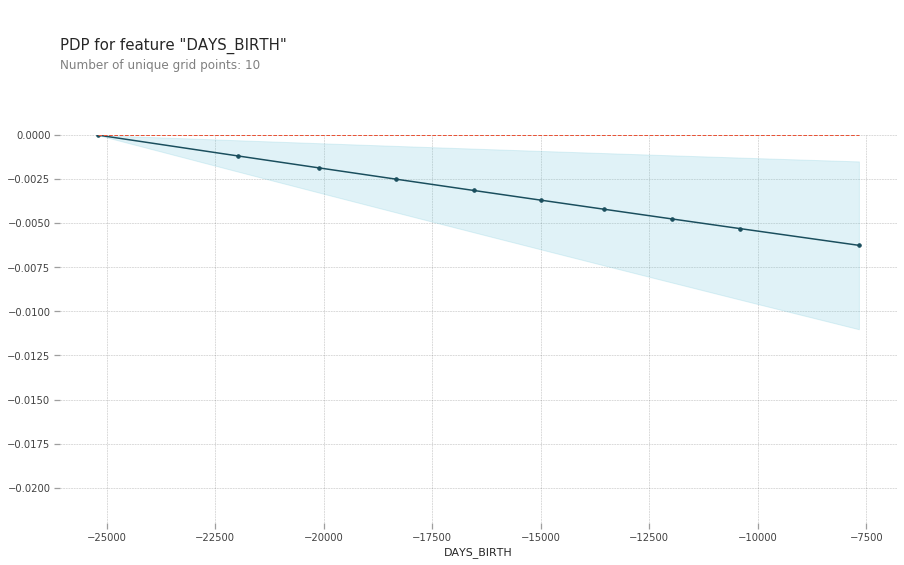

<Figure size 1152x864 with 0 Axes>

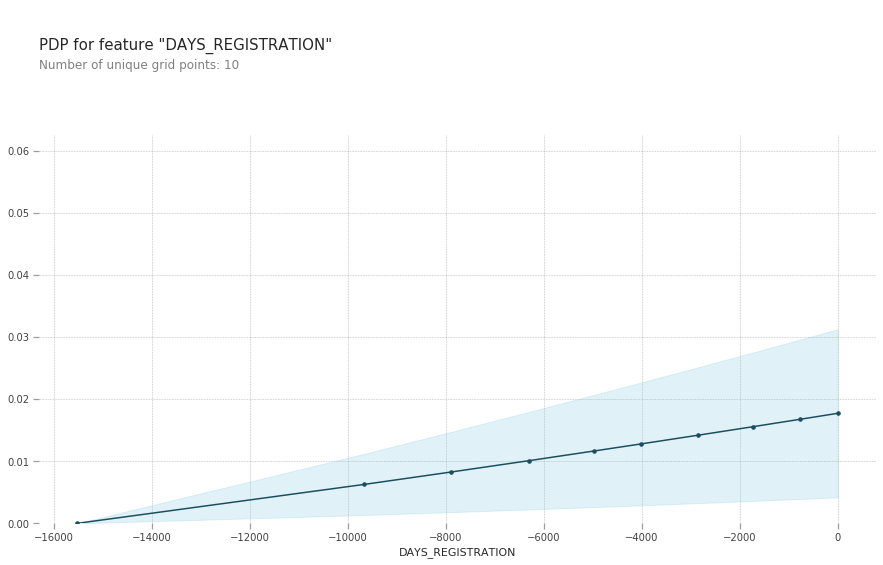

In [40]:


for item in selected_features:
  plot_a_pdp_pls(item)

# Pair Plots

In [41]:
# SADLY, the pair plots were not working

In [42]:
# aug_data.loc[~aug_data.index.duplicated(), :]

In [43]:
# y_train

In [44]:
# train_data_pp = x_train[selected_features]
# train_data_pp['TARGET'] = y_train
# train_data_pp.drop_duplicates()

In [45]:
# train_data_pp

In [46]:
# top3 = train_data_pp[['EXT_SOURCE_3','EXT_SOURCE_2','NONLIVINGAREA_AVG','TARGET']]


In [47]:
# # not working
# sns.pairplot(aug_data, hue='TARGET', diag_kind='hist')
# sns.pairplot(top3.drop_duplicates(), hue='TARGET', diag_kind='hist')

# plt.show()

# SHAP

In [48]:
# # must redo this everytime a new session is set up - reinstall the shap package - moved to the import section of the script
# !pip install shap

In [49]:
import shap

# set up the dataset

X = aug_data[selected_features]
Y = aug_data['TARGET']

X_train, _, Y_train, _ = train_test_split(X, Y, test_size = 0.3)
model.fit(X_train, Y_train)

backgroundsample = shap.utils.sample(X, 500) # background dist


In [50]:
# compute the SHAP values for the linear model
# explainer = shap.Explainer(model).shap_values(X_train)
explainer = shap.LinearExplainer(model,backgroundsample)
shap_values = explainer(X)

In [51]:
# Y_train[110521] # check the true value at this point (it's zero)

In [52]:
# force plot for where target = 0
shap.initjs()
shap.force_plot(shap_values[110521,:], aug_data.iloc[110521,:])


In [53]:
# force plot for where target = 1
shap.initjs()
shap.force_plot(shap_values[126369,:], aug_data.iloc[126369,:])

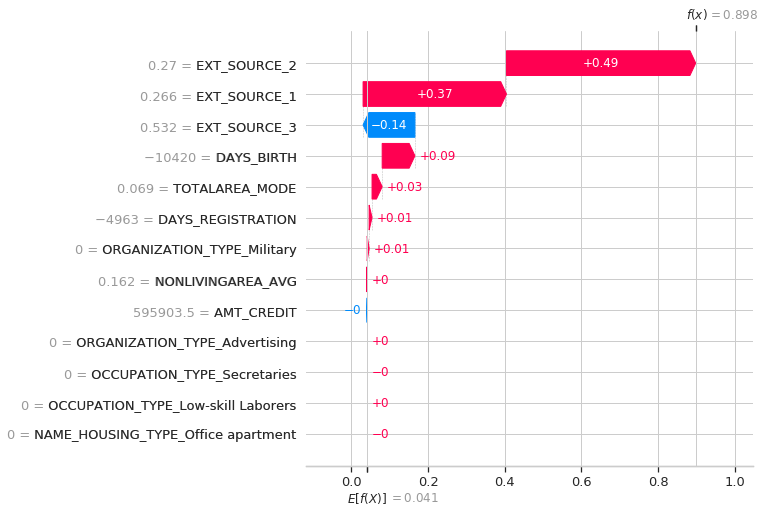

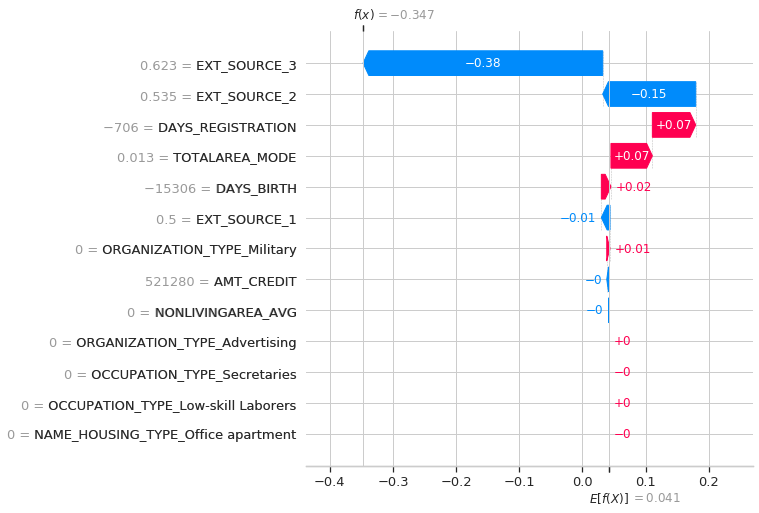

In [54]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 110521
shap.plots.waterfall(shap_values[sample_ind], max_display=14)
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 126369
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

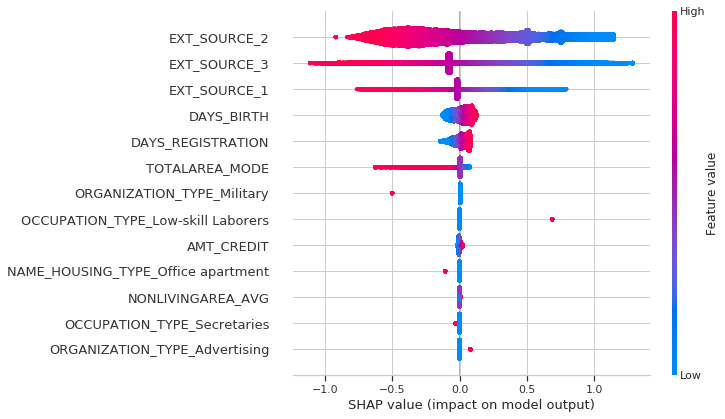

In [55]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values, max_display=14)

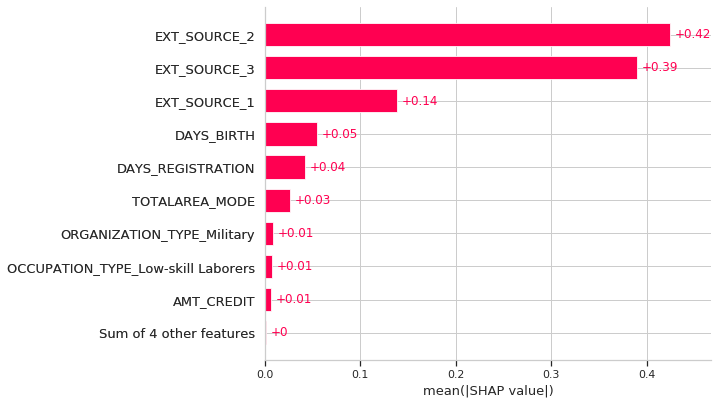

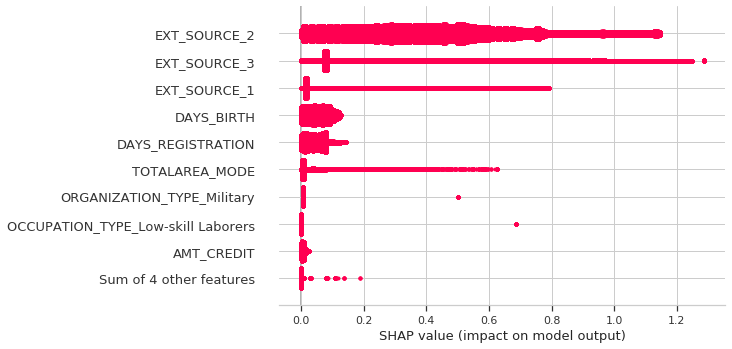

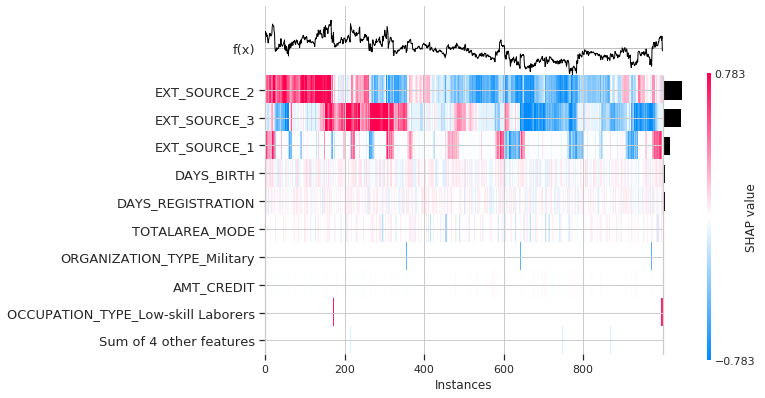

In [56]:
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values.abs, color="shap_red")
shap.plots.heatmap(shap_values[:1000])
# shap.plots.scatter(shap_values[:,"AMT_GOODS_PRICE"], color=shap_values)


# Final Metrics
* AUC score
* Accuracy
* Precision
* Recall

In [57]:
# Compute AUC score
roc = roc_auc_score(y_test,y_pred_proba)

In [58]:
# need yhat
model.fit(x_train.iloc[:20000,:], y_train[:20000])

# # # xtest still has highly correlated columns and outliers unlike train
# common_cols = [col for col in set(x_train.columns).intersection(x_test.columns)]
# x_test_new = x_test[common_cols]

y_hat = model.predict(x_test)

In [59]:
# AUC Score
print("AUC score:",roc)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_hat))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_hat))

AUC score: 0.5873537724194811
Accuracy: 0.9171840354767185
Precision: 0.48623853211009177
Recall: 0.01420150053590568
